# Image Resizing

<br/>

<pre>
dataset:      imagewoof testset
resizing to:  128x128
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagenette dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagenette dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

To test our detection method on natural OoD samples at inference we aim to conduct an experiment using the test samples of the [Imagewoof dataset](https://github.com/fastai/imagenette). We chose [Imagewoof](https://github.com/fastai/imagenette) as it is similar to [Imagenette](https://github.com/fastai/imagenette). It is also a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). However, [Imagewoof](https://github.com/fastai/imagenette) and [Imagenette](https://github.com/fastai/imagenette) do not share any classes. [Imagenette](https://github.com/fastai/imagenette) contains very different object classes (e.g., golf ball, church, parachute), while [Imagewoof](https://github.com/fastai/imagenette) contains classes of different dog breeds. [Imagenette](https://github.com/fastai/imagenette) also contains a class representing a certain dog breed but that particular dog breed is not part of the [Imagewoof dataset](https://github.com/fastai/imagenette).

We aim to train our model using the [Imagenette dataset](https://github.com/fastai/imagenette). All of the [Imagenette](https://github.com/fastai/imagenette) images need to be of the same size for model training. We chose a size of 128x128 (see __resize_imagenette_128.ipynb__ for explanation). As a result, we need to resize [Imagewoof](https://github.com/fastai/imagenette) to 128x128 as well.

An easy way to do the resizing would be to resize the images of the dataset using the resize batch transform. Then, every time we load a batch the images for this batch will be resized to the  desired size. However, we are not sure if the resize transform will not be changed in the future or if it even works the same every time it is used. Although we think that this scenario is rather unlikely, we still chose to resize the whole dataset once and use the resized dataset for all subsequent steps instead (to make sure we will not run into any resizing-related problems later).

<br/>

_Sources:_
* [Imagenette dataset](https://github.com/fastai/imagenette)
* [Imagewoof dataset](https://github.com/fastai/imagenette)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
from torchvision import transforms, datasets
import PIL
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform
from pathlib import Path
import random

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('PIL version:         {}'.format(PIL.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
PIL version:         8.0.1
numpy version:       1.19.5
matplotlib version:  3.2.2
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
base_data_folder  = Path('/Users/lehmann/research/laca3/datasets/imagewoof')
img_size          = 128
fname_string      = 'imagewoof_testset_{}'.format(img_size)

## Function for Displaying Images

In [4]:
labels = (
    'Samoyed',
    'English foxhound',
    'Old English sheepdog',
    'Rhodesian ridgeback',
    'beagle',
    'Australian terrier',
    'golden retriever',
    'dingo',
    'Shih-Tzu',
    'Border terrier'
)

imagenet_norm = {
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225)
}

def show_samples(data, targets, normalized=False):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        if normalized:
            img[0] = img[0] * imagenet_norm['std'][0] + imagenet_norm['mean'][0]
            img[1] = img[1] * imagenet_norm['std'][1] + imagenet_norm['mean'][1]
            img[2] = img[2] * imagenet_norm['std'][2] + imagenet_norm['mean'][2]
            img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Download Data

The dataset is available in size 320 and size 160. We chose size 320 here as it is not clear how the images were downsized. Thus, we prefer the larger size.

In [5]:
# Original data folder
orig_folder_name = 'imagewoof2-320'
orig_dataset_path = base_data_folder/orig_folder_name

# Download data
!rm -rf {str(orig_dataset_path)}
!cp -r /Users/lehmann/.fastai/data/{orig_folder_name} {str(orig_dataset_path)}

To be able to load the dataset into batches we need to have all images of the same size. The folder name _imagewoof2-320_ suggests that all images of the dataset are of the size 320x320. However, in reality only one dimension of each image seems to have size 320. Thus, we need to add a resizing to 320x320 for loading the dataset into PyTorch.

In [6]:
orig_data_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor()
])

In [7]:
# Data path
orig_test_path = orig_dataset_path/'val'

# Test set 
orig_testset = datasets.ImageFolder(
    root=str(orig_test_path), transform=orig_data_transform
)

# Create test dataloader
orig_testloader = torch.utils.data.DataLoader(
    orig_testset, batch_size=1000, shuffle=True, num_workers=0
)

# Check size of the test set
orig_test_size = len(orig_testloader.dataset)
print('testset size:  {}'.format(orig_test_size))

testset size:  3929


tensor shape: (1000, 3, 320, 320)

min pixel value: 0.0
max pixel value: 1.0


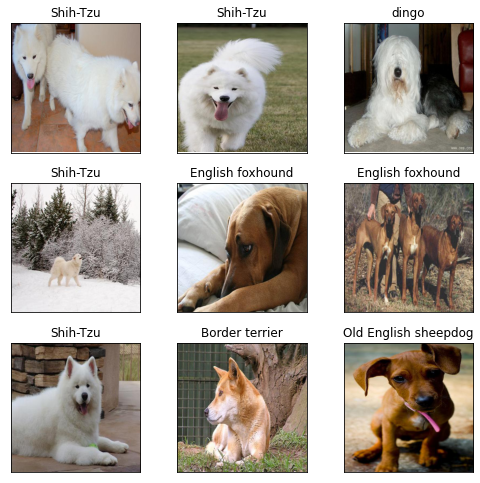

In [8]:
# Display a few test images
orig_test_dataiter = enumerate(orig_testloader)
_, (orig_test_sample_data, orig_test_sample_targets) = next(orig_test_dataiter)

show_samples(orig_test_sample_data, orig_test_sample_targets)

## Resize Data

In [9]:
def resize_data(data_path, size):
    for class_folder in data_path.iterdir():
        for image_file in class_folder.iterdir():
            with Image.open(image_file) as img:
                img_resized = img.resize((size,size))
                img_resized.save(image_file)

Before resizing the data we make a copy of the dataset to avoid destroying the original data.

In [10]:
# Data paths of original data copy folder and resized data folder
origcopy_dataset_path = Path(str(orig_dataset_path)+'-copy')
dataset_path = base_data_folder/fname_string

# Removing old folders and copy the original data folder
!rm -rf {str(dataset_path)}
!rm -rf {str(origcopy_dataset_path)}
!cp -r {str(orig_dataset_path)} {str(origcopy_dataset_path)}

In [11]:
# Data path
origcopy_test_path = origcopy_dataset_path/'val'

# Resize the images of the test set
resize_data(origcopy_test_path, img_size)

After resizing we rename the folder according to the new size.

In [12]:
!mv {str(origcopy_dataset_path)} {str(base_data_folder/fname_string)}

In [13]:
# Data paths
test_path = dataset_path/'val'

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

# Test set 
testset = datasets.ImageFolder(
    root=str(test_path), transform=data_transform
)

# Create test dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=False, num_workers=0
)

# Check size of the test set
test_size = len(testloader.dataset)
dataset_correct =  test_size == orig_test_size

print('dataset correct: {}'.format(dataset_correct))
print('testset size:  {}'.format(test_size))

dataset correct: True
testset size:  3929


tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


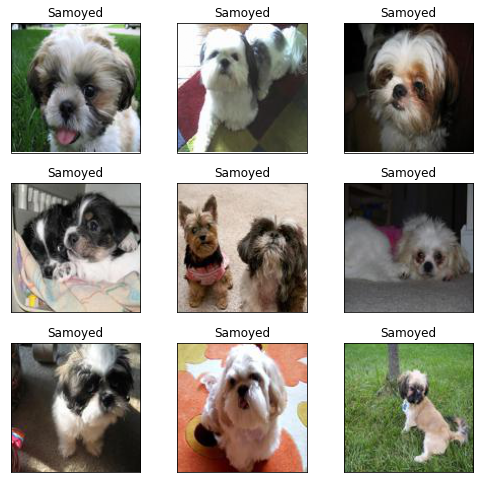

In [14]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets, True)

## Store Images as Pth File

To store our test set for later we simply save the test dataloader. Then, we can use it later to test our method on these test samples as natural OoD samples.

In [15]:
# Remove old pth file and create new one
!rm -f {str(base_data_folder/fname_string)+'.pth'}
torch.save(testloader, str(base_data_folder/fname_string)+'.pth')